# Project: Writing an Algorithm for a Dog Identification App 
---
**A Machine Learning Engineer Nanodegree Project**

In this project I have developing an algorithm that could be used as part of a mobile or web app. The app accepts any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed. If a human is detected, it will provide an estimate of the dog breed that is most resembling.

This project is from [Udacity Machine Learning Engineer Nanodegre](https://eu.udacity.com/).


### The Road Ahead

The notebook are broken into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write the Algorithm
* [Step 6](#step6): Test tje Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [19]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

train_files, train_targets = load_dataset('/data/dog_images/train')
valid_files, valid_targets = load_dataset('/data/dog_images/valid')
test_files, test_targets = load_dataset('/data/dog_images/test')

dog_names = [item[20:-1] for item in sorted(glob("/data/dog_images/train/*/"))]

print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

print(train_targets[-1])

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.]


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

human_files = np.array(glob("/data/lfw/*/*"))
random.shuffle(human_files)

print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


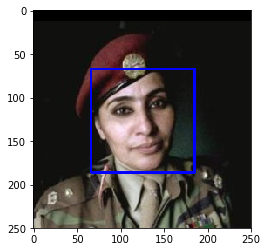

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Assess the Human Face Detector

We are going to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

human_files = np.average([face_detector(img) for img in human_files_short])
dog_files = np.average([face_detector(img) for img in dog_files_short])

print ("Accuracy Humans {}, Accuracy Dogs {}" .format(human_files, dog_files))

Accuracy Humans 1.0, Accuracy Dogs 0.11


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images. We are using the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/).

In [7]:
from keras.applications.resnet50 import ResNet50

ResNet50_model = ResNet50(weights='imagenet')

102858752/102853048 [==============================] - 1s 0us/step


### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [12]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

img_path='images/dog1.jpg'

### Making Predictions with ResNet-50

In [13]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

Writing a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.

In [14]:
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

#### Assess the Dog Detector

In [15]:
human_files = np.average([dog_detector(img) for img in human_files_short])
dog_files = np.average([dog_detector(img) for img in dog_files_short])
print ("Accuracy Humans {}, Accuracy Dogs {}" .format(human_files, dog_files))

Accuracy Humans 0.0, Accuracy Dogs 1.0


---
<a id='step3'></a>
## Step 3: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [19]:
bottleneck_features = np.load('/data/bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [20]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [21]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [22]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s 292us/step - loss: 12.2922 - acc: 0.1184 - val_loss: 10.5793 - val_acc: 0.2192
Epoch 2/20
6680/6680 [==============================] - 2s 249us/step - loss: 10.0321 - acc: 0.2873 - val_loss: 9.9953 - val_acc: 0.2910
Epoch 3/20
6680/6680 [==============================] - 2s 247us/step - loss: 9.5150 - acc: 0.3473 - val_loss: 9.6335 - val_acc: 0.3305
Epoch 4/20
6680/6680 [==============================] - 2s 247us/step - loss: 9.1828 - acc: 0.3825 - val_loss: 9.5006 - val_acc: 0.3401
Epoch 5/20
6680/6680 [==============================] - 2s 253us/step - loss: 8.9907 - acc: 0.4094 - val_loss: 9.3069 - val_acc: 0.3437
Epoch 6/20
6680/6680 [==============================] - 2s 248us/step - loss: 8.6296 - acc: 0.4262 - val_loss: 8.9149 - val_acc: 0.3760
Epoch 7/20
6680/6680 [==============================] - 2s 250us/step - loss: 8.4485 - acc: 0.4496 - val_loss: 8.8612 - val_acc: 0.388

### Load the Model with the Best Validation Loss

In [23]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [24]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 43.6603%


### Predict Dog Breed with the Model

In [25]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

We use transfer learning to create a CNN that can identify dog breed from images.

In Step 3, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, we create a CNN to classift dog breeds using transfer learning.

### Obtain Bottleneck Features

In [26]:
bottleneck_features = np.load('/data/bottleneck_features/DogResnet50Data.npz')
train_ResNet50 = bottleneck_features['train']
valid_ResNet50 = bottleneck_features['valid']
test_ResNet50 = bottleneck_features['test']

### Model Architecture

The ResNet50 model provide the features extraction and the following architecture the task of inference. The new dataset is small and it has some similarities with `image_net` dataset so all the weights from the pre-trained network are frozen.

We have added a global average pooling layer for reducing the dimensionality of the output of the convolutional neural network. The next layer added has been a fully connected layer with 128 nodes for learning more especifically about new data with sigmoid as activation function. Finally, we have added a fully connected layer with 133 nodes with softmax activation to obtain probabilites of the predicion.

In [27]:
ResNet50_model = Sequential()
ResNet50_model.add(GlobalAveragePooling2D(input_shape=train_ResNet50.shape[1:]))
ResNet50_model.add(Dense(128, activation='sigmoid'))
ResNet50_model.add(Dense(133, activation='softmax'))

ResNet50_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               262272    
_________________________________________________________________
dense_4 (Dense)              (None, 133)               17157     
Total params: 279,429
Trainable params: 279,429
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [28]:
ResNet50_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Train the Model

In [29]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50.hdf5', 
                               verbose=1, save_best_only=True)

ResNet50_model.fit(train_ResNet50, train_targets, 
          validation_data=(valid_ResNet50, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s 316us/step - loss: 3.1317 - acc: 0.4407 - val_loss: 1.8557 - val_acc: 0.6922
Epoch 2/20
6680/6680 [==============================] - 2s 262us/step - loss: 1.2880 - acc: 0.7799 - val_loss: 1.1033 - val_acc: 0.7820
Epoch 3/20
6680/6680 [==============================] - 2s 258us/step - loss: 0.7665 - acc: 0.8654 - val_loss: 0.8451 - val_acc: 0.8024
Epoch 4/20
6680/6680 [==============================] - 2s 290us/step - loss: 0.5215 - acc: 0.9064 - val_loss: 0.7096 - val_acc: 0.8192
Epoch 5/20
6680/6680 [==============================] - 2s 294us/step - loss: 0.3754 - acc: 0.9419 - val_loss: 0.6471 - val_acc: 0.8287
Epoch 6/20
6680/6680 [==============================] - 2s 286us/step - loss: 0.2772 - acc: 0.9671 - val_loss: 0.5925 - val_acc: 0.8479
Epoch 7/20
6680/6680 [==============================] - 2s 261us/step - loss: 0.2036 - acc: 0.9802 - val_loss: 0.5697 - val_acc: 0.8407
E

### Load the Model with the Best Validation Loss

In [30]:
ResNet50_model.load_weights('saved_models/weights.best.Resnet50.hdf5')

### Test the Model

In [31]:
ResNet50_predictions = [np.argmax(ResNet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_ResNet50]

test_accuracy = 100*np.sum(np.array(ResNet50_predictions)==np.argmax(test_targets, axis=1))/len(ResNet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 84.4498%


### Predict Dog Breed with the Model

The function below takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

In [32]:
def ResNet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = ResNet50_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]    

---
<a id='step5'></a>
## Step 5: Write the Algorithm

The next algorithm accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

In [43]:
from IPython.core.display import Image, display

def detecting_image(img_path):
    display(Image(image_path,width=200,height=200))
    if face_detector(img_path):
        return "It is a human face! he/she looks like a {}".format(ResNet50_predict_breed(img_path))
    if dog_detector(img_path):
        return "The predicted dog breed is {}".format(ResNet50_predict_breed(img_path))
    else:
        return "There are not a dog or human face in the image"

---
<a id='step6'></a>
## Step 6: Test the Algorithm


### Test the Algorithm on Sample Images!

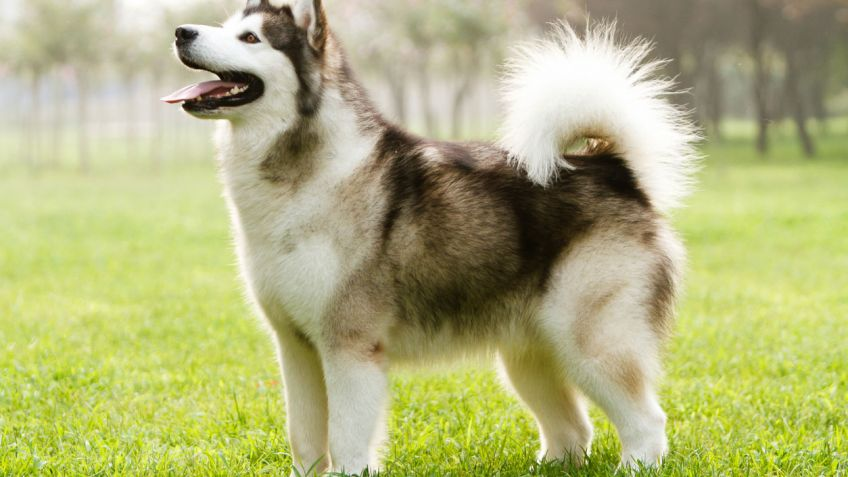

'The predicted dog breed is in/005.Alaskan_malamute'

In [42]:
image_path='images/dog1.jpg'
detecting_image(image_path)

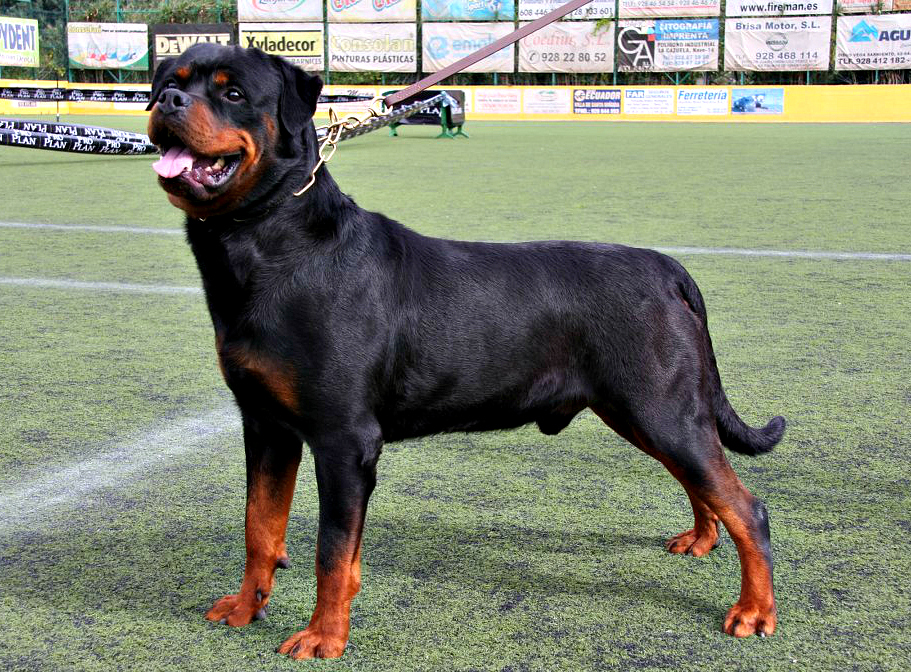

'The predicted dog breed is in/059.Doberman_pinscher'

In [36]:
image_path='images/dog2.jpg'
detecting_image(image_path)

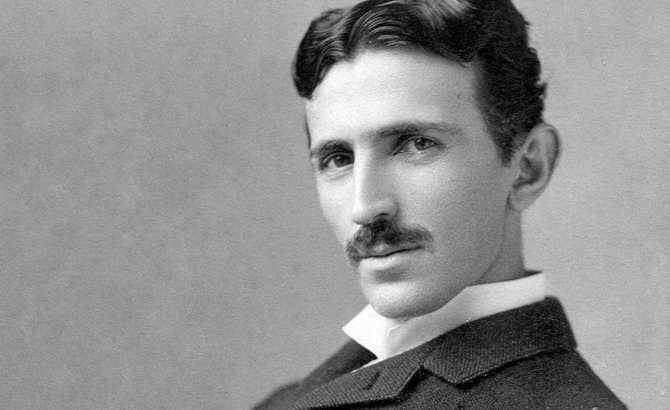

'It is a human face! he/she looks like a in/001.Affenpinscher'

In [37]:
image_path='images/human1.jpg'
detecting_image(image_path)

In [1]:
image_path='images/human3.jpg'
detecting_image(image_path)

NameError: name 'detecting_image' is not defined

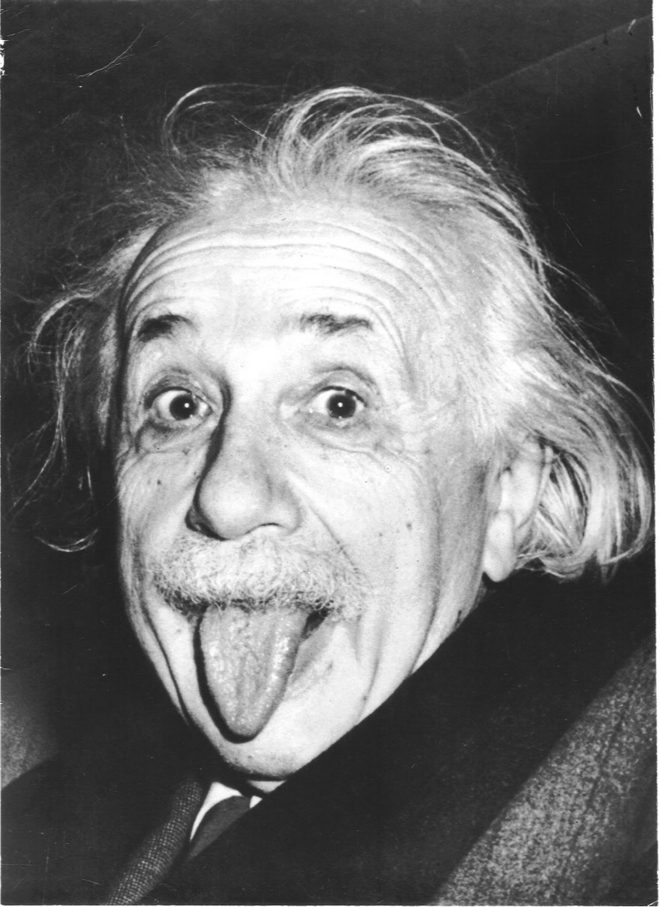

'It is a human face! he/she looks like a in/066.Field_spaniel'

In [38]:
image_path='images/human2.jpg'
detecting_image(image_path)

### Three possible points of improvement:
- Using Image Augmentation to incresing traning dataset and the prediction for images with differents prospects.
- Accuracy could be improved if we increase the depth of the neural network.
- Prediction multiple in one image, counting the dogs and humans existing in the image.